In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import anndata2ri
import logging
from scipy.sparse import csr_matrix, issparse
import numpy as np
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scipy as sp

import scanpy.external as sce
import scib
import matplotlib



import sys
from sklearn.linear_model import LinearRegression
import preprocessing
import utils
import check_if_nan

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

os.chdir('/root/host_home')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.1.0
anndata2ri                  1.3.1
anyio                       NA
arrow                       1.3.0
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
cairo                       1.26.0
certifi                     2023.11.17
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.3.2
check_if_nan                NA
cloudpickle                 3.0.0
comm                        0.2.1
cupy                        12.3.0
cupy_backends               NA
cupyx                       NA
cycler                      0.12.1
cython_runtime              NA
dask                        2023.11.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1

In [2]:
%%R -o Rpackages

library(scran)
library(BiocParallel)
library(biomaRt)
library(scry)

print(R.version)
Rpackages = as.data.frame(installed.packages())


               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          2.3                         
year           2023                        
month          03                          
day            15                          
svn rev        83980                       
language       R                           
version.string R version 4.2.3 (2023-03-15)
nickname       Shortstop Beagle            


Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [3]:
a = pd.DataFrame(Rpackages)
a.to_csv('Rversions.csv')

# Filenames

In [4]:
#Filename scanpy AnnData input for lp NPC after demultiplexing
adata_input_lp = 'lp_NPCs/processed_data/lp_NPC_filtered_cuda.h5ad'


#Filename scanpy AnnData output for NPC after demultiplexing
adata_out_normalized = 'lp_NPCs/processed_data/lp_NPC_normalized_cuda.h5ad'
adata_out_cell_cycle = 'lp_NPCs/processed_data/lp_NPC_cell_cycle_cuda.h5ad'


In [5]:
lane_key = "lane"
donor_key = "Donor"
dataset_key = "cultivation_period"
label_key = "condition"

# Read in data

In [6]:
adata = sc.read(adata_input_lp)


In [7]:
adata

AnnData object with n_obs × n_vars = 30843 × 17250
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'n_cells'
    uns: 'Donor_colors', 'lane_colors'
    layers: 'counts', 'soupX_counts'

# Normalization

## scran normalization 

In [8]:
#adata = sc.read(adata_out_filtered)

In [9]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum = 1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups", resolution=0.5)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=15
    finished (0:00:35)
computing neighbors
    using 'X_pca' with n_pcs = 15


2024-05-16 17:33:08.130404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
running Leiden clustering
    finished: found 14 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:18)


In [10]:
data_mat = adata.X.T

if sp.sparse.issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [11]:
del adata_pp

In [12]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [13]:
adata.obs['size_factors'] = size_factors

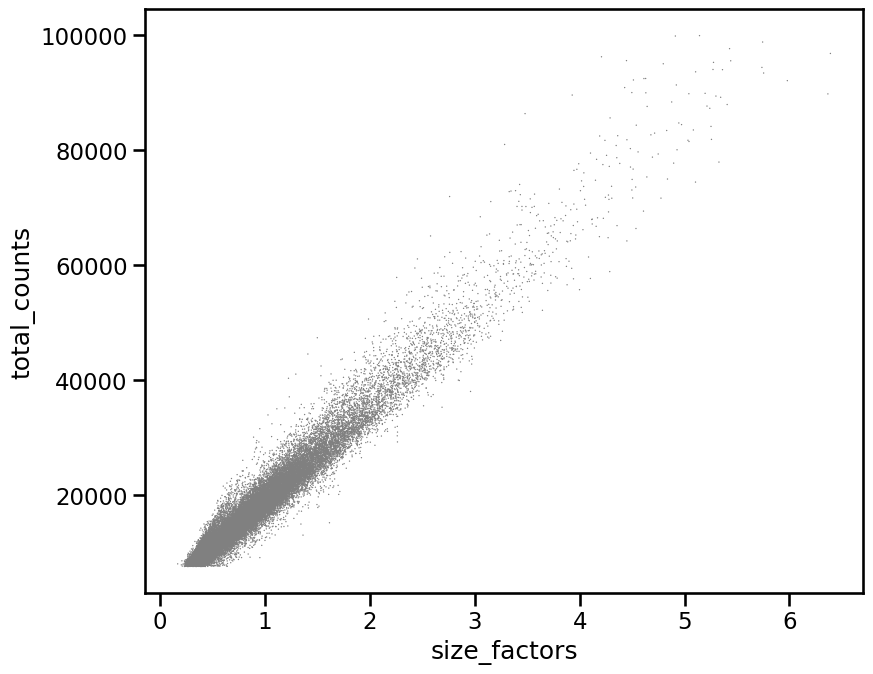

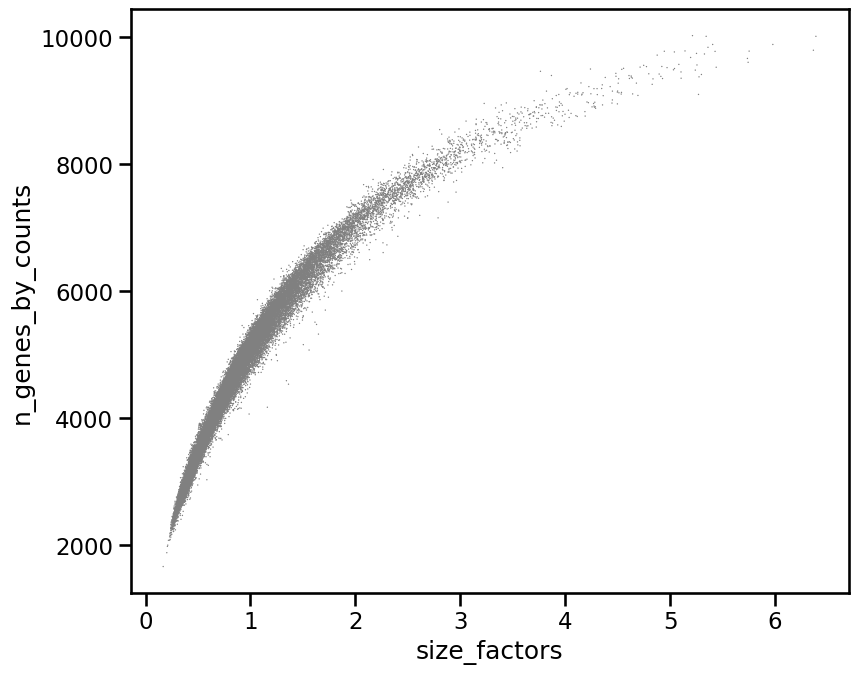

<Axes: ylabel='Count'>

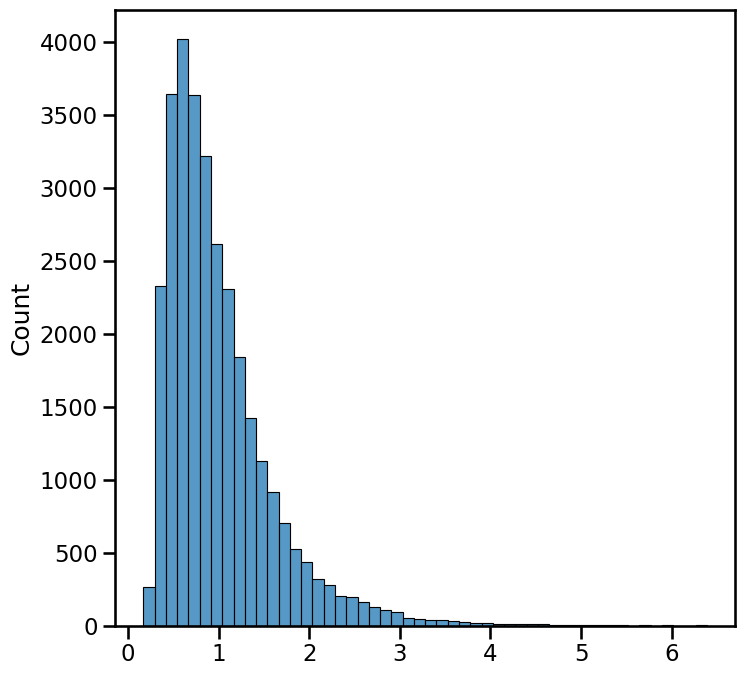

In [14]:
# Visualize the estimated size factors

sc.pl.scatter(adata, 'size_factors', 'total_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes_by_counts')

sb.histplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

In [15]:
#Normalize adata 
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [16]:
%%R
rm(list = ls())

## log1p proportional fitting

In [17]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:01)


## Data summary statistics

In [18]:
adata

AnnData object with n_obs × n_vars = 30843 × 17250
    obs: 'Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_score', 'size_factors'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'n_cells'
    uns: 'Donor_colors', 'lane_colors'
    layers: 'counts', 'soupX_counts', 'scran_normalization', 'log1p_norm'

In [19]:
#Recalculate total counts after filtering
adata.obs['total_counts'] = adata.X.sum(1)

In [20]:
adata.obs['Donor'].value_counts()

Donor
UKERiPX7-R1-001    5354
UKERiO3H-R1-005    3256
UKERi88H-R1-002    2980
UKERiAY6-R1-003    2591
UKERi82A-R1-002    2496
UKERi1E4-R1-003    2406
UKERiR66-R1-007    2340
UKERiM89-R1-005    2143
UKERiC99-R1-007    2051
UKERiG3G-R1-039    2042
UKERiJ2C-R1-015    1686
UKERi1JF-R1-018    1498
Name: count, dtype: int64

In [21]:
adata.obs.groupby(by='Donor')['total_counts'].median()

Donor
UKERi1E4-R1-003    15349.5
UKERi1JF-R1-018    14393.0
UKERi82A-R1-002    17092.5
UKERi88H-R1-002    15095.0
UKERiAY6-R1-003    15149.0
UKERiC99-R1-007    15182.0
UKERiG3G-R1-039    16904.5
UKERiJ2C-R1-015    18081.5
UKERiM89-R1-005    14550.0
UKERiO3H-R1-005    16298.0
UKERiPX7-R1-001    15381.0
UKERiR66-R1-007    12574.0
Name: total_counts, dtype: float64

In [22]:
#Use scran normalized counts
adata.X = adata.layers["scran_normalization"]

# Write data to file

In [23]:
#adata.write(adata_out_normalized)
#adata_1.obs.to_csv('test.csv')


#sc.pp.combat(adata, key = 'Lane')

#  Feature selection

In [24]:
#adata = sc.read(adata_out_normalized)

In [25]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="cell_ranger")

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [26]:
adata.var['highly_variable_genes'] = adata.var['highly_variable']

## Visualization

<Axes: xlabel='means', ylabel='dispersions'>

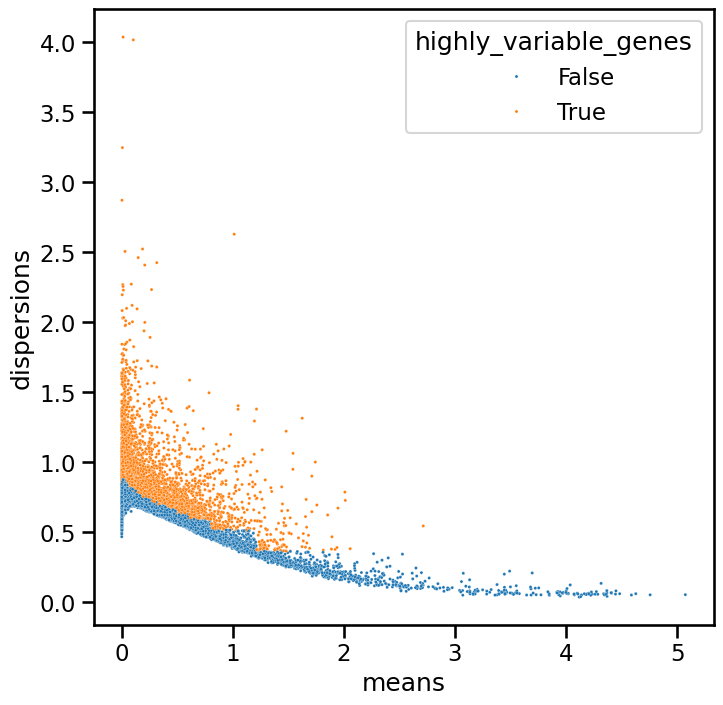

In [27]:
sb.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_variable_genes", s=5)
plt.show()

## Dimensionality reduction

In [28]:
adata.var['highly_variable'] = adata.var['highly_variable_genes']
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver="arpack")
sc.pp.neighbors(adata)

computing PCA
    with n_comps=50
    finished (0:00:25)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


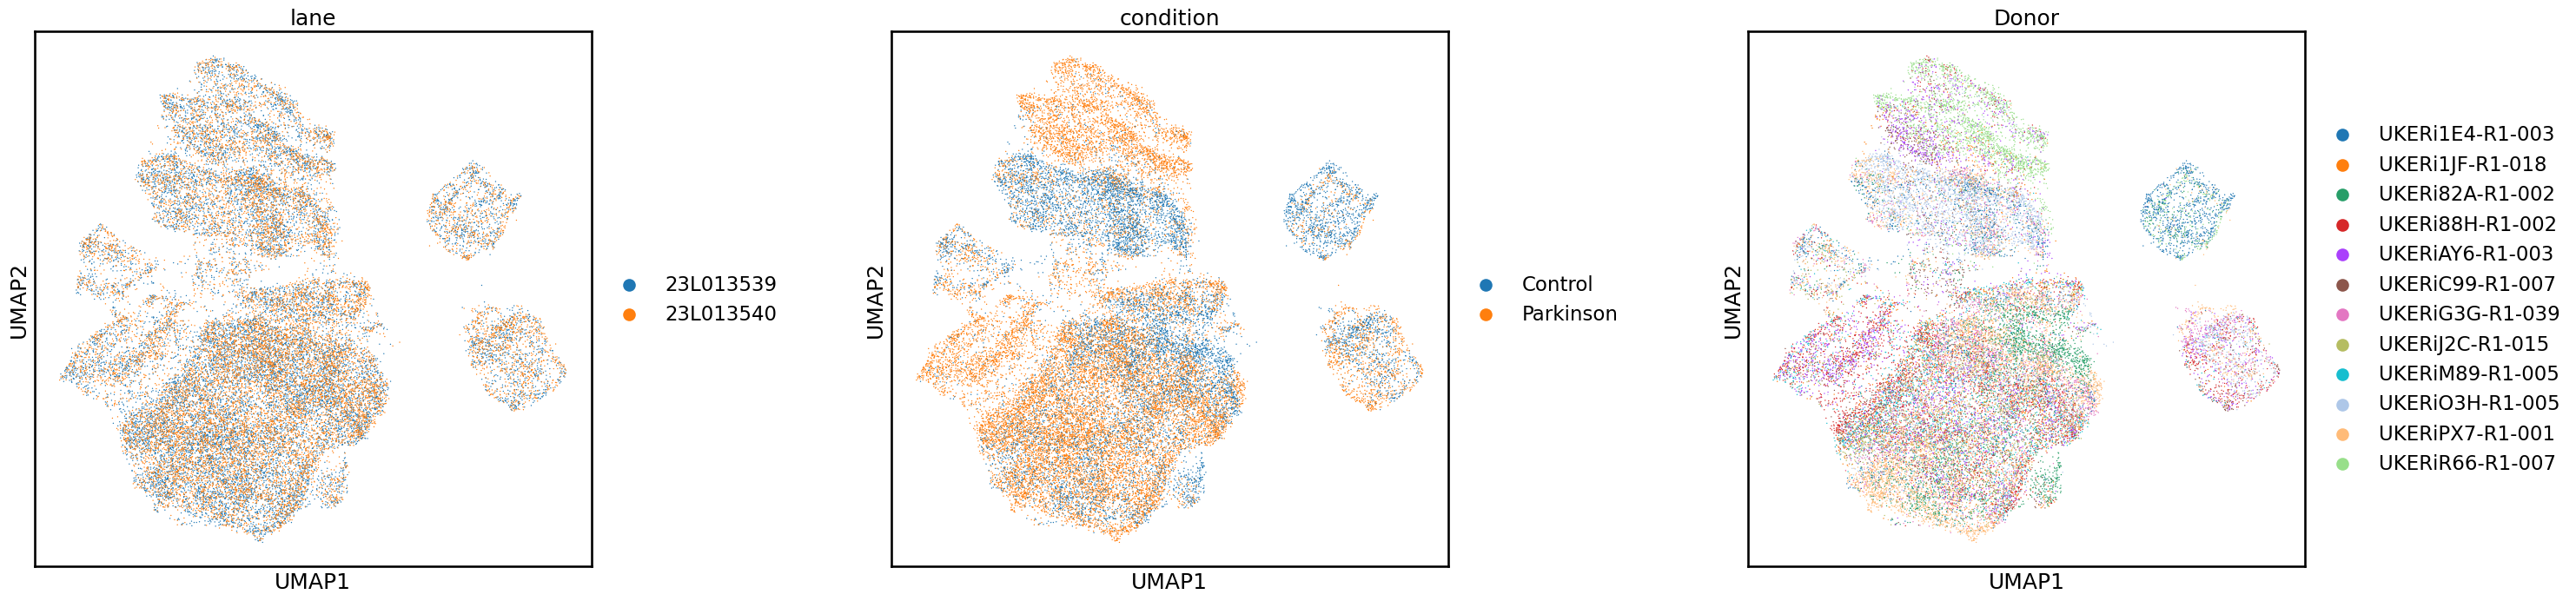

In [30]:
sc.pl.umap(adata, color=["lane","condition", "Donor"], wspace = 0.4)

# Cell cycle scoring

In [31]:
#%%R
#library(RCurl)
#cc_file <- getURL("https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Homo_sapiens.csv") 
#cell_cycle_genes <- read.csv(text = cc_file)

In [32]:
#%%R -o cell_cycle_genes
#library(biomaRt)
#gene_symbols <- as.character(cell_cycle_genes$geneID)

#mart = useDataset("hsapiens_gene_ensembl", useEnsembl(biomart="ensembl", version=108))

#attribute <- c("ensembl_gene_id", "external_gene_name", "hgnc_symbol")

#G_list <- getBM(filters= "ensembl_gene_id", attributes= attribute,values=gene_symbols,mart=mart)



#cell_cycle_genes$ensemblID = G_list[match(gene_symbols, G_list$ensembl_gene_id),]$ensembl_gene_id
#cell_cycle_genes$symbol = G_list[match(gene_symbols, G_list$ensembl_gene_id),]$hgnc_symbol

#write.csv(cell_cycle_genes, 'general_input_files/cc_genes_tirosh_human.txt', row.names = FALSE)

In [33]:
cell_cycle_genes = pd.read_csv('general_input_files/cc_genes_tirosh_human.txt')

In [34]:
cell_cycle_genes

phase           geneID modified        ensemblID  symbol
0   G2/M  ENSG00000010292  9/13/17  ENSG00000010292  NCAPD2
1   G2/M  ENSG00000011426  9/13/17  ENSG00000011426    ANLN
2   G2/M  ENSG00000013810  9/13/17  ENSG00000013810   TACC3
3   G2/M  ENSG00000072571  9/13/17  ENSG00000072571    HMMR
4   G2/M  ENSG00000075218  9/13/17  ENSG00000075218   GTSE1
..   ...              ...      ...              ...     ...
92     S  ENSG00000175305  9/13/17  ENSG00000175305   CCNE2
93     S  ENSG00000176890  9/13/17  ENSG00000176890    TYMS
94     S  ENSG00000197299  9/13/17  ENSG00000197299     BLM
95     S  ENSG00000198056  9/13/17  ENSG00000198056   PRIM1
96     S  ENSG00000276043  9/13/17  ENSG00000276043   UHRF1

[97 rows x 5 columns]

In [35]:
cell_cycle_genes = cell_cycle_genes[cell_cycle_genes.symbol.isin(adata.var.gene_symbols)]
s_genes = cell_cycle_genes[cell_cycle_genes.phase == 'S'].symbol.values.tolist()
g2m_genes = cell_cycle_genes[cell_cycle_genes.phase == 'G2/M'].symbol.values.tolist()

In [36]:
#Score cell cycle and visualize the effect:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    559 total control genes are used. (0:00:02)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    426 total control genes are used. (0:00:02)
-->     'phase', cell cycle phase (adata.obs)


In [37]:
adata.obs.phase.value_counts()

phase
G2M    10917
S      10151
G1      9775
Name: count, dtype: int64

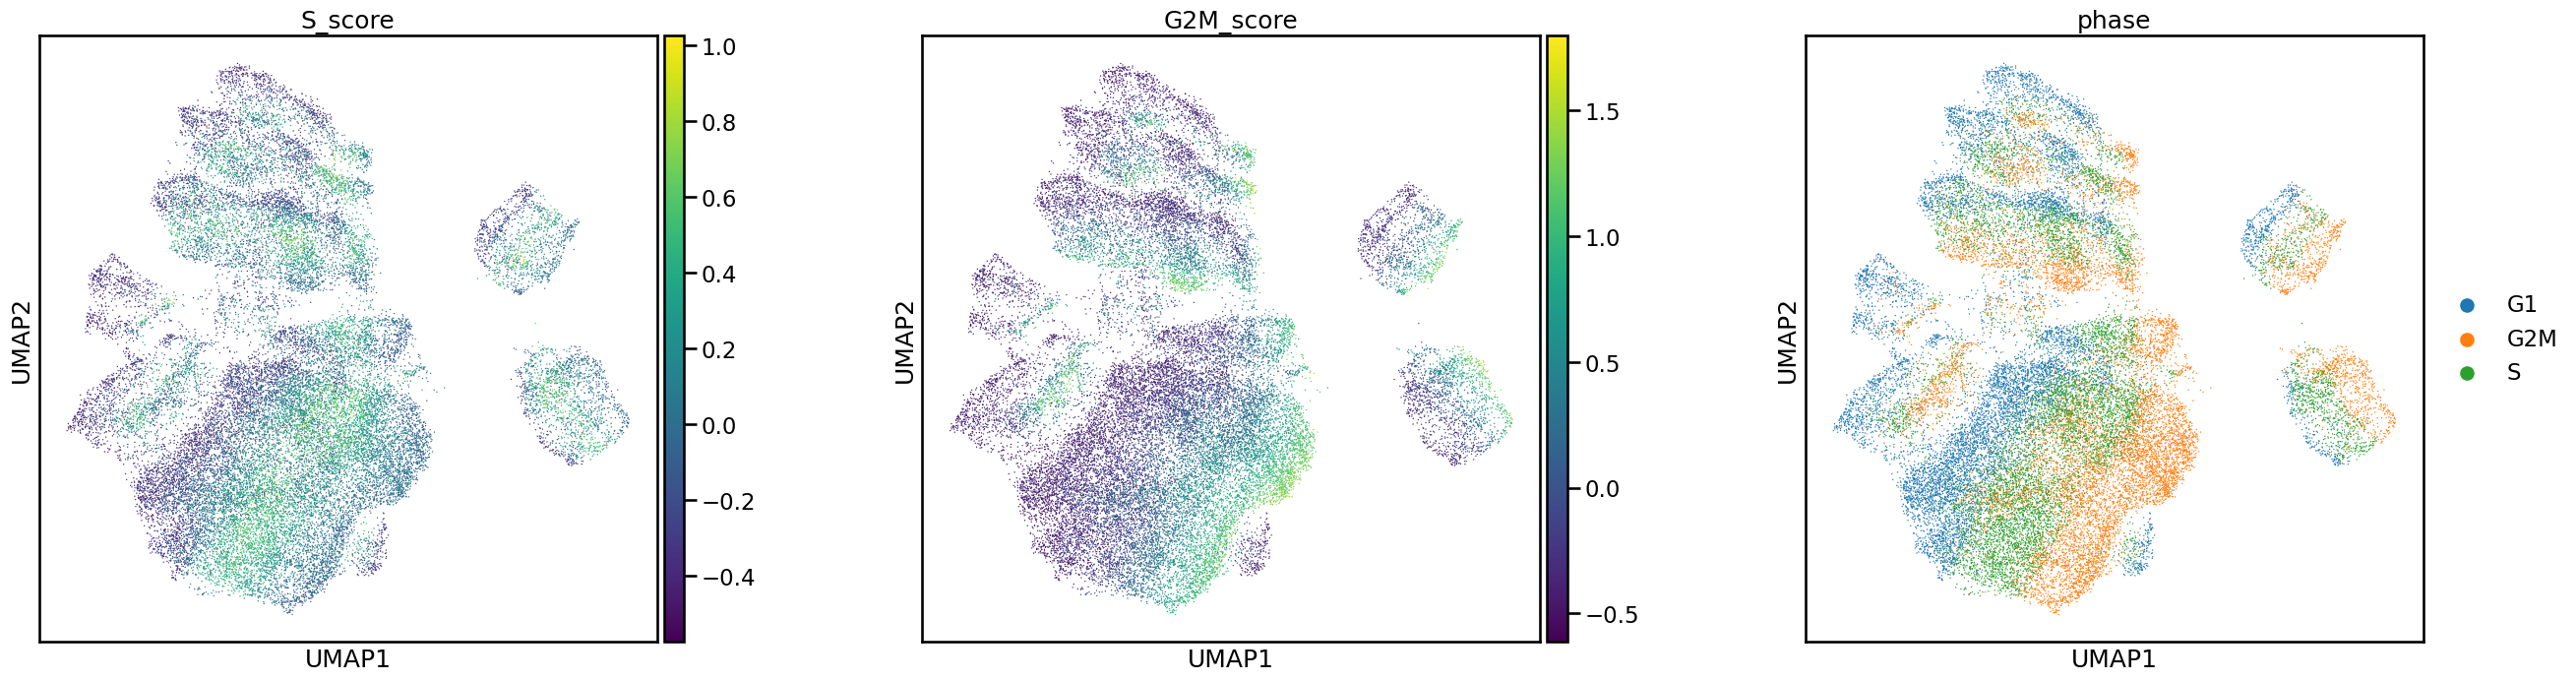

In [38]:
# Tirosh CC gene scoring
sc.pl.umap(adata, color=['S_score', 'G2M_score', 'phase'], wspace = 0.3)

# Evaluate batch effects

Here, we compute the variance contribution of covariates. 

In [39]:
adata_pca = adata.copy()

In [40]:
sc.pp.pca(adata, n_comps=50, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:26)


In [41]:
n_pcs = 50

specifiy covariates we want to check (we will quantify their correlation with the 1st 50 PCs, to see how much variance they can each explain):

In [42]:
covariates = ['Donor', 'lane', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'phase']

In [43]:
def check_if_nan(arr, *args, **kwarg):
    if isinstance(arr, np.ndarray):
        x_nans = np.isnan(arr)
    else:
        x_nans = arr.isna()
    return x_nans

Now check for every covariate, for every PC how much variance among the cells' PC scores the covariate can explain. Add this variance explained per PC up across PCs for every covariate. This will give us the total amount of variance explained per covariate.

In [44]:
var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
for pc in range(n_pcs):
    y_true_unfiltered = adata_pca.obsm["X_pca"][:, pc]
    var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
    for cov in covariates:
        x = adata_pca.obs[cov].values.copy()
        x_nans = check_if_nan(x)
        x = x[~x_nans]
        if len(x) != 0:
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
            else:
                if len(set(x)) == 1:
                    var_explained.loc[pc, cov] = np.nan
                    continue
                x = pd.get_dummies(x)
            lrf = LinearRegression(fit_intercept=True).fit(
                x,
                y_true,
            )
            y_pred = lrf.predict(x)
            var_explained.loc[pc, cov] = np.var(y_pred)
total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)
total_variance_explained_fractions = (
    total_variance_explained / total_variance_explained["overall"]
)

In [45]:
total_variance_explained.sort_values(ascending=False, inplace=True)

<Figure size 800x400 with 0 Axes>

<BarContainer object of 13 artists>

Text(0.5, 1.0, 'covariate correlation with first 50 PCs')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'cultivation_period'),
  Text(1, 0, 'lane'),
  Text(2, 0, 'age'),
  Text(3, 0, 'deltaUPDRS'),
  Text(4, 0, 'gender'),
  Text(5, 0, 'deltaHY'),
  Text(6, 0, 'deltaADL'),
  Text(7, 0, 'years_of_illness'),
  Text(8, 0, 'deltaDOPA'),
  Text(9, 0, 'condition'),
  Text(10, 0, 'Donor'),
  Text(11, 0, 'phase'),
  Text(12, 0, 'overall')])

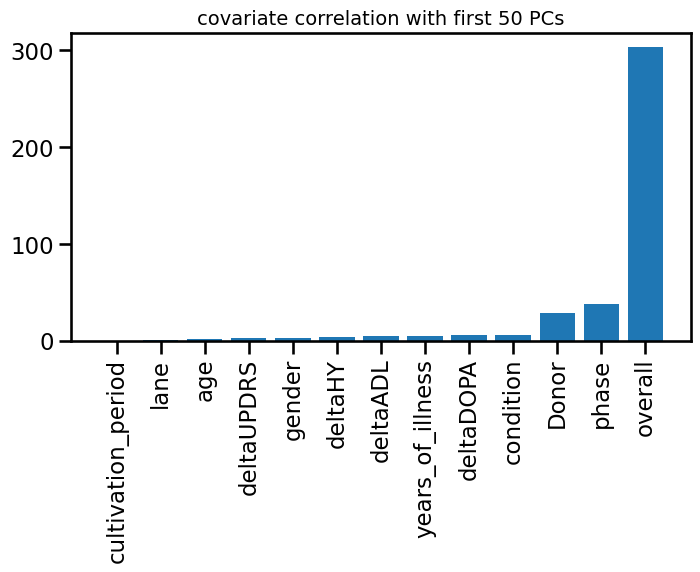

In [46]:
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained[::-1].index,
    total_variance_explained[::-1].values,
)
plt.title(
    f"covariate correlation with first 50 PCs",
    fontsize=14,
)  # \n({dominant_type})
plt.xticks(rotation=90)
plt.show()

We will consider donor as a batch effect. Dataset will be corrected for the cell cycle phase in the next steps to refine clustering.

In [47]:
del adata_pca

#  Feature selection - batch aware

In [48]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="cell_ranger", batch_key='Donor')

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [49]:
adata.var.highly_variable.value_counts()

highly_variable
False    13250
True      4000
Name: count, dtype: int64

In [50]:
adata.var.highly_variable_intersection.value_counts()

highly_variable_intersection
False    15908
True      1342
Name: count, dtype: int64

highly_variable_nbatches
0     8370
1     1852
12    1342
2     1166
3      953
4      709
5      591
6      449
11     395
7      383
8      362
10     344
9      334
Name: count, dtype: int64

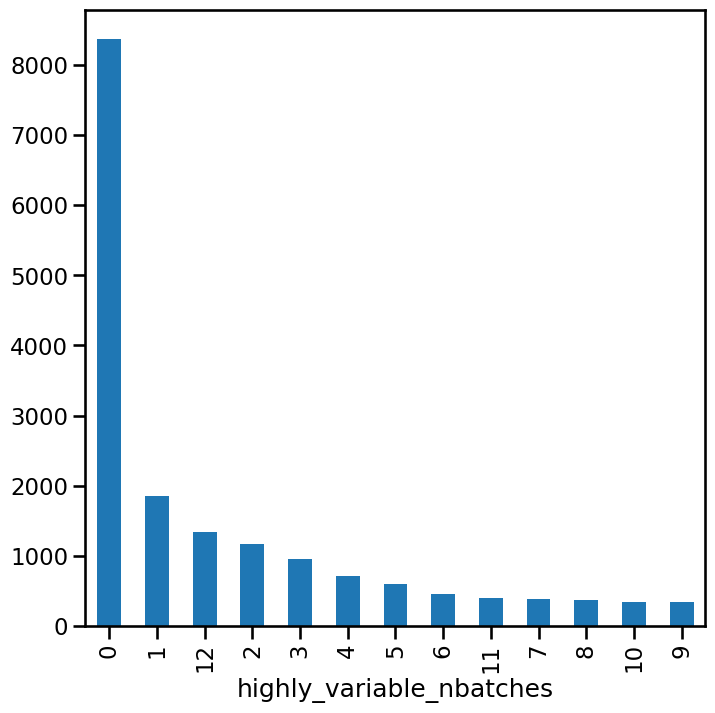

In [51]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [52]:
adata.var['highly_variable_genes_batch_aware'] = adata.var['highly_variable']

## Visualization

<Axes: xlabel='means', ylabel='dispersions'>

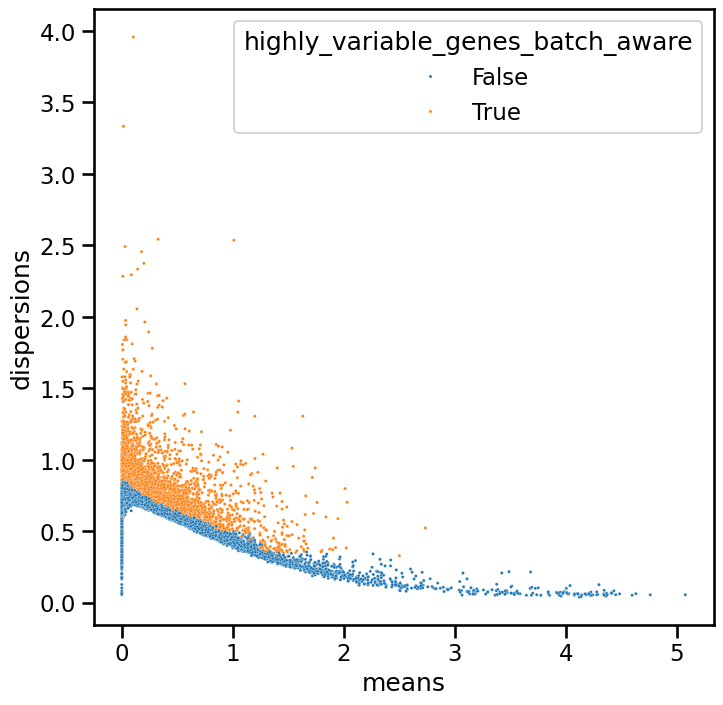

In [53]:
sb.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_variable_genes_batch_aware", s=5)
plt.show()

## Dimensionality reduction

In [54]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver="arpack")
sc.pp.neighbors(adata)

computing PCA
    with n_comps=50
    finished (0:00:26)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [55]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


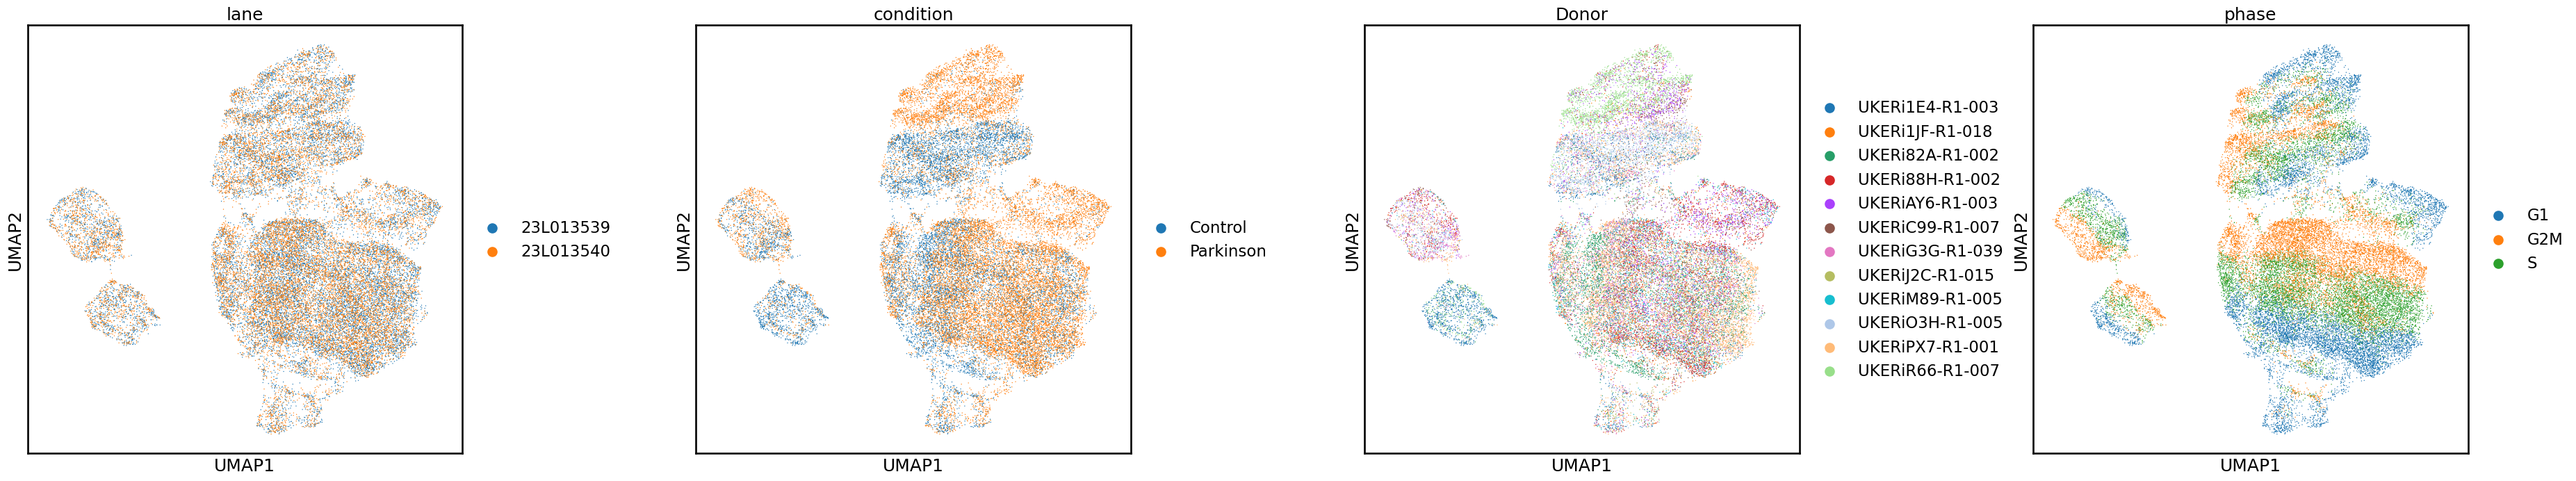

In [56]:
sc.pl.umap(adata, color=["lane","condition", "Donor", 'phase'], wspace = 0.4)

# Write data to file

In [57]:
adata.raw = adata

In [58]:
adata.write(adata_out_cell_cycle)